In [1]:
import pandas as pd  # data processing, CSV file I/O
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

# make a plot outputs appear and be stored within the notebook
%matplotlib inline

print("Complete")

Complete


In [2]:
LETTER_NAMES = {
    1: "alif",
    10: "ra",
    11: "zay",
    12: "sin",
    13: "shin",
    14: "sad",
    15: "dad",
    16: "da",
    17: "za",
    18: "ayn",
    19: "gayn",
    2: "ba",
    20: "fa",
    21: "qaf",
    22: "kaf",
    23: "lam",
    24: "mim",
    25: "non",
    26: "ha",
    27: "waw",
    28: "ya",
    29: "hamza",
    3: "ta",
    4: "tha",
    5: "gim",
    6: "ha",
    7: "kha",
    8: "dal",
    9: "thal"
}

In [3]:
x_train = pd.read_csv("./X_train.csv")
y_train = pd.read_csv("./y_train.csv")

In [4]:
print(x_train.columns)
print(y_train.columns)
assert len(x_train) == len(y_train)

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel1014', 'pixel1015', 'pixel1016', 'pixel1017', 'pixel1018',
       'pixel1019', 'pixel1020', 'pixel1021', 'pixel1022', 'pixel1023'],
      dtype='object', length=1024)
Index(['label'], dtype='object')


In [5]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37933 entries, 0 to 37932
Columns: 1024 entries, pixel0 to pixel1023
dtypes: int64(1024)
memory usage: 296.4 MB


In [6]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37933 entries, 0 to 37932
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   37933 non-null  int64
dtypes: int64(1)
memory usage: 296.5 KB


### Distributions

<AxesSubplot:>

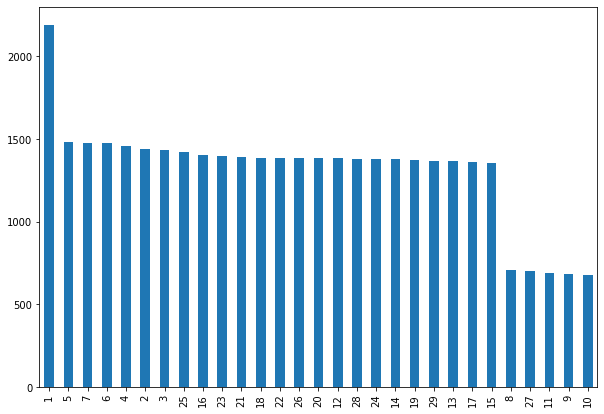

In [7]:
plt.figure(figsize=(10,7))
y_train['label'].value_counts().plot(kind="bar")

In [8]:
max([x_train[column].max() for column in x_train.columns] )

255

So each pixel takes value 0-255

### Changing data format to compatible with tf training

Shuffling

In [9]:
idx = np.random.permutation(x_train.index)
x_train = x_train.reindex(idx)
y_train = y_train.reindex(idx)

In [10]:
x_train_tf = tf.convert_to_tensor(x_train)
x_train_tf = x_train_tf / 255 # normalisation from 0 - 255 to 0 - 1
x_train_tf

<tf.Tensor: shape=(37933, 1024), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])>

In [11]:
y_train_tf = y_train - 1
y_train_tf

,label
4675,2
33583,25
35270,27
3294,1
21193,16
...,...
26095,19
1497,0
18660,14
21814,16


### Test data
For assessing accuracy, loss, etc

In [12]:
x_test = pd.read_csv("./X_test.csv")
y_test = pd.read_csv("./y_test.csv")

In [13]:
x_test_tf = tf.convert_to_tensor(x_test)
x_test_tf = x_test_tf / 255 # normalisation from 0 - 255 to 0 - 1
y_test_tf = y_test - 1
y_test_tf

,label
0,0
1,0
2,0
3,0
4,0
...,...
9496,28
9497,28
9498,28
9499,28


### TF model

In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
NUMBER_OF_LAYERS = 6

In [22]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=1024))

    for i in range(NUMBER_OF_LAYERS):
        # Tune the number of units in the first Dense layer
        # Choose an optimal value between 4-1024
        hp_units = hp.Int(f'units_{i}', min_value=5, max_value=516, step=3)
        model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))

    model.add(tf.keras.layers.Dense(29))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    return model

In [23]:
tuner = kt.Hyperband(model_builder,
    objective='val_accuracy',
    max_epochs=100,
    factor=3,
    project_name='hyperparams')

In [24]:
tuner.search(x_train_tf, y_train_tf, epochs=100, validation_split=0.1, shuffle=True, callbacks=[stop_early])

Trial 254 Complete [00h 00m 36s]
val_accuracy: 0.5079072117805481

Best val_accuracy So Far: 0.542171835899353
Total elapsed time: 01h 03m 15s
INFO:tensorflow:Oracle triggered exit


In [25]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
print(f"learning_rate: {best_hps.get('learning_rate')}")
for i in range(NUMBER_OF_LAYERS):
    print(f"Layer {i}: {best_hps.get(f'units_{i}')}")

learning_rate: 0.001
Layer 0: 491
Layer 1: 269
Layer 2: 218
Layer 3: 104
Layer 4: 113
Layer 5: 299


In [26]:
history = model.fit(x_train_tf, y_train_tf, epochs=300, shuffle=True, validation_split=0.1, callbacks=[stop_early])

Epoch 1/300
1067/1067 [==============================] - 3s 3ms/step - loss: 2.6300 - accuracy: 0.2168 - val_loss: 2.2082 - val_accuracy: 0.3184
Epoch 2/300
1067/1067 [==============================] - 3s 3ms/step - loss: 1.9439 - accuracy: 0.3844 - val_loss: 1.9266 - val_accuracy: 0.3951
Epoch 3/300
1067/1067 [==============================] - 3s 3ms/step - loss: 1.5809 - accuracy: 0.4894 - val_loss: 1.7761 - val_accuracy: 0.4294
Epoch 4/300
1067/1067 [==============================] - 3s 3ms/step - loss: 1.3313 - accuracy: 0.5628 - val_loss: 1.7023 - val_accuracy: 0.4792
Epoch 5/300
1067/1067 [==============================] - 3s 3ms/step - loss: 1.1332 - accuracy: 0.6260 - val_loss: 1.6739 - val_accuracy: 0.5003
Epoch 6/300
1067/1067 [==============================] - 3s 3ms/step - loss: 0.9788 - accuracy: 0.6732 - val_loss: 1.7175 - val_accuracy: 0.4989
Epoch 7/300
1067/1067 [==============================] - 3s 3ms/step - loss: 0.8420 - accuracy: 0.7194 - val_loss: 1.7438 - val_ac

In [27]:
test_loss, test_acc = model.evaluate(x_test_tf,  y_test_tf, verbose=2)

print('\nTest accuracy:', test_acc)

297/297 - 0s - loss: 2.0783 - accuracy: 0.5285 - 362ms/epoch - 1ms/step

Test accuracy: 0.5284706950187683
